In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
# Se organizan las imagenes en 5 directorios: Angry, Happy, Poo, Sad, Surprised
path = 'Emojis/'

emojis = []
labels = ['Angry', 'Happy', 'Poo', 'Sad', 'Surprised']
for label in labels:
    folder = os.path.join(path, label)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                emojis.append((img, label))

print("Número total de imágenes cargadas:", len(emojis)) 


Número total de imágenes cargadas: 2530


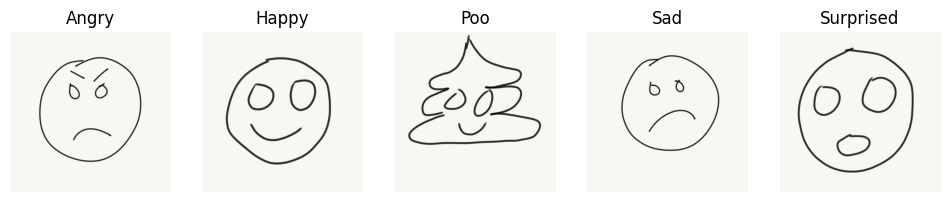

In [3]:
# Muestra una imagen de cada categoría
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    for img, img_label in emojis:
        if img_label == label:
            plt.subplot(1, 5, i + 1)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            break

In [8]:
# Procesamiento de las imagenes, pasar a escala de grises, a un tamaño de 32x32 píxeles.
# Ademas, encontrar la zona de trazo y recortarlo para centrarla en la imagen.
def preprocess_image(img):
    if img is None or img.size == 0:
        # Si la imagen está vacía o no se pudo leer, retorna una imagen negra
        return np.zeros((36, 36), dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Imagen binaria (fondo blanco, trazos negros)
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    contours_data = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours_data[-2]
    min_area = 30
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    if valid_contours:
        try:
            all_points = np.vstack(valid_contours)
            x, y, w, h = cv2.boundingRect(all_points)
            roi = binary[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (32, 32), interpolation=cv2.INTER_AREA)
            padded = np.pad(roi_resized, ((2, 2), (2, 2)), mode='constant', constant_values=0)
            return padded
        except Exception as e:
            # Si ocurre un error en el procesamiento, retorna la imagen binaria redimensionada
            return cv2.resize(binary, (36, 36), interpolation=cv2.INTER_AREA)
    else:
        return cv2.resize(binary, (36, 36), interpolation=cv2.INTER_AREA)

preprocessed_emojis = [(preprocess_image(img), label) for img, label in emojis]
print("Número total de imágenes preprocesadas:", len(preprocessed_emojis))

Número total de imágenes preprocesadas: 2530


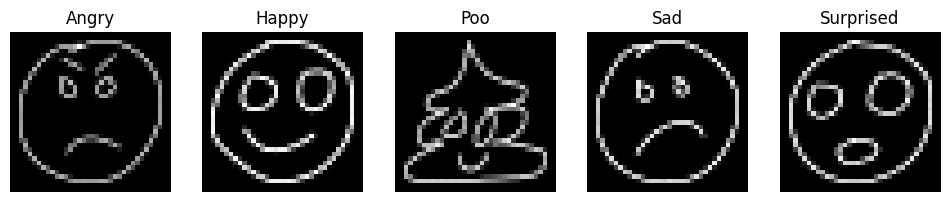

In [9]:
#Muestra una imagen de cada categoría preprocesada
plt.figure(figsize=(12, 8))
for i, label in enumerate(labels):
    for img, img_label in preprocessed_emojis:
        if img_label == label:
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')
            break

In [11]:
# Con las imágenes binarias, ajusta un modelo MLP y evalúa su rendimiento
X = np.array([img for img, label in preprocessed_emojis])
y = np.array([labels.index(label) for img, label in preprocessed_emojis])
X = X.reshape(-1, 36, 36, 1) / 255.0  # Normaliza y ajusta la forma para Keras
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
y_train_cat = to_categorical(y_train, num_classes=len(labels))
y_test_cat = to_categorical(y_test, num_classes=len(labels))
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train_cat.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test_cat.shape)

# Construcción del modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(36, 36, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(labels), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Entrenamiento del modelo
history = model.fit(X_train, y_train_cat, epochs=15, batch_size=16, validation_split=0.1)
# Evaluación del modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print("Pérdida en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)
# Predicciones y reporte de clasificación
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=labels))

Forma de X_train: (2024, 36, 36, 1)
Forma de y_train: (2024, 5)
Forma de X_test: (506, 36, 36, 1)
Forma de y_test: (506, 5)


c:\Users\celes\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,997 (1.61 MB)

 Trainable params: 420,997 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6842 - loss: 0.8154 - val_accuracy: 0.8522 - val_loss: 0.4059
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6842 - loss: 0.8154 - val_accuracy: 0.8522 - val_loss: 0.4059
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8753 - loss: 0.3622 - val_accuracy: 0.9113 - val_loss: 0.2982
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8753 - loss: 0.3622 - val_accuracy: 0.9113 - val_loss: 0.2982
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9138 - loss: 0.2409 - val_accuracy: 0.9064 - val_loss: 0.2432
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9138 - loss: 0.2409 - val_accuracy: 0.9064 - val_loss: 0.2432
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9423 - loss: 0.1677 - val_accuracy: 0.9064 - val_loss: 0.2533
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9423 - loss: 0.1677 - val_accuracy: 

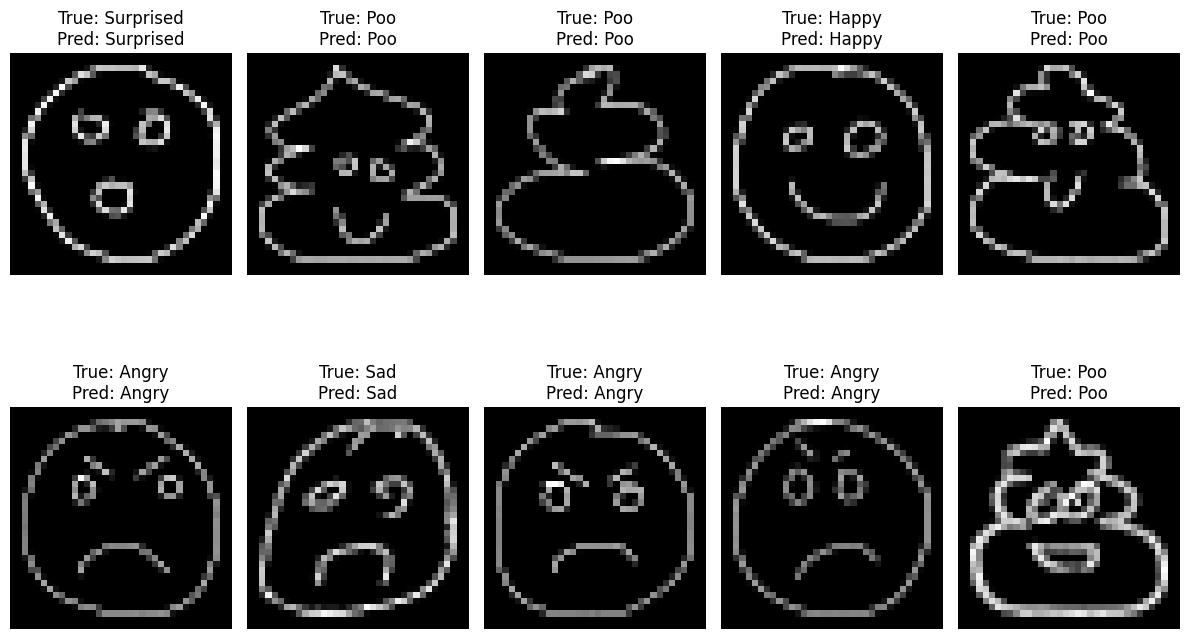

In [12]:
# Realiza predicciones con la CNN entrenada y muestra algunas imágenes de prueba con sus predicciones
plt.figure(figsize=(12, 8))
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(36, 36)
    true_label = labels[y_test[idx]]
    pred_label = labels[y_pred_classes[idx]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()